In [1]:
%%capture
!pip install torch torchvision

In [2]:
import torch
import math
from skimage import data
from matplotlib import pyplot as plt
from matplotlib import rcParams as params
params['figure.figsize']= [8, 8]

def show(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

(512, 512)


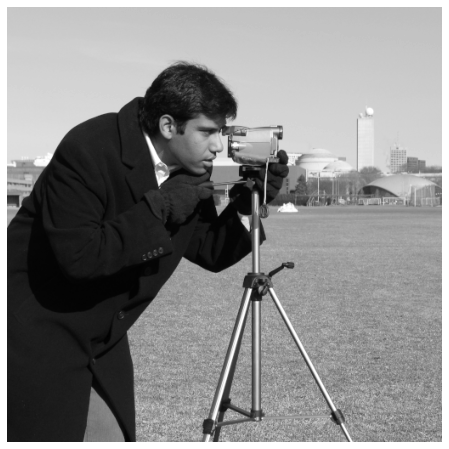

In [3]:
image = data.camera()
print(image.shape)

show(image)

## Convert to torch tensor

In [4]:
x = torch.tensor(image).view(1,1,image.shape[0],image.shape[1])
print(x.size())
print(x.dtype)
x = x.to(torch.float32)
print(x.dtype)

torch.Size([1, 1, 512, 512])
torch.uint8
torch.float32


## Decompose in blocks

In [5]:
N=8

bs, _, h, w = x.size()
x = x.view(bs, 1, h, w)

# make NxN blocs out of image
blocks = torch.nn.functional.unfold(x, kernel_size=(N, N), stride=(N, N)) # shape (1, NxN, block_num)
blocks = blocks.transpose(1, 2)
blocks = blocks.view(bs, 1, -1, N, N) # shape (bs, 1, block_num, N, N)

## DCT

In [6]:
def _dct_matrix(N: int) -> torch.Tensor:
    r"""
    Computes the matrix coefficients for DCT transform
    Following this formula https://fr.mathworks.com/help/images/discrete-cosine-transform.html

    Args:
        N: size of DCT matrix to create (N, N)
    """
    p = torch.arange(1,N).view((N-1, 1))
    q = torch.arange(1,2*N,2)
    return torch.cat((
        math.sqrt(1/N)*torch.ones((1,N)),
        math.sqrt(2/N) * torch.cos(math.pi / (2 * N) * p * q)), 0)

In [7]:
# apply DCT transform
coeffs = _dct_matrix(N)

if x.is_cuda:
    coeffs = coeffs.cuda()

blocks = coeffs @ blocks @ coeffs.t() # @ does matmul on last 2 channels only

## Apply mask

In [8]:
torch.set_printoptions(precision=2)

print(blocks[:,:,0,:,:].view(8,8))

tensor([[ 1.60e+03,  2.27e+00, -1.35e-01,  3.31e-01,  5.00e-01,  3.82e-01,
          3.27e-01, -1.21e+00],
        [-7.70e-01, -7.59e-01, -8.49e-01,  9.32e-01, -8.53e-01,  7.95e-01,
         -1.39e-01, -1.22e-01],
        [ 6.53e-01,  1.07e+00, -6.77e-01,  4.95e-01, -2.71e-01,  1.20e-01,
          4.27e-01, -1.60e-01],
        [-5.63e-01,  1.07e+00, -2.45e-01, -2.01e-01, -4.98e-01,  4.36e-01,
          2.74e-01, -5.11e-01],
        [ 5.00e-01,  8.26e-01,  7.89e-01, -5.17e-01, -3.70e-07, -2.58e-01,
         -5.60e-02,  5.99e-01],
        [-1.12e-01,  4.69e-01, -4.88e-02,  8.22e-02, -8.46e-01, -7.99e-01,
         -9.49e-02, -3.90e-01],
        [ 2.70e-01, -1.31e+00, -7.32e-02, -1.08e-01,  6.53e-01,  4.35e-01,
         -3.23e-01,  6.42e-01],
        [ 1.15e+00, -4.75e-01, -2.66e-01, -8.38e-01, -2.44e-01, -5.26e-01,
          2.08e-01, -2.41e-01]])


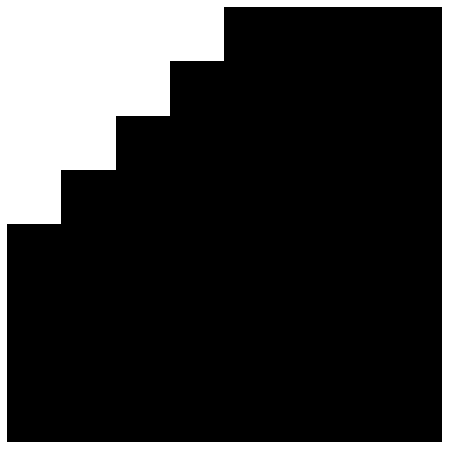

In [9]:
mask = torch.tensor([[1, 1, 1, 1, 0, 0, 0, 0],
[1, 1, 1, 0, 0, 0, 0, 0],
[1, 1, 0, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
show(mask)

In [10]:
# test on 1 block
masked = blocks[:,:,0,:,:].view(8,8) * mask
print(masked)

tensor([[ 1.60e+03,  2.27e+00, -1.35e-01,  3.31e-01,  0.00e+00,  0.00e+00,
          0.00e+00, -0.00e+00],
        [-7.70e-01, -7.59e-01, -8.49e-01,  0.00e+00, -0.00e+00,  0.00e+00,
         -0.00e+00, -0.00e+00],
        [ 6.53e-01,  1.07e+00, -0.00e+00,  0.00e+00, -0.00e+00,  0.00e+00,
          0.00e+00, -0.00e+00],
        [-5.63e-01,  0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  0.00e+00,
          0.00e+00, -0.00e+00],
        [ 0.00e+00,  0.00e+00,  0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,
         -0.00e+00,  0.00e+00],
        [-0.00e+00,  0.00e+00, -0.00e+00,  0.00e+00, -0.00e+00, -0.00e+00,
         -0.00e+00, -0.00e+00],
        [ 0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  0.00e+00,  0.00e+00,
         -0.00e+00,  0.00e+00],
        [ 0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,
          0.00e+00, -0.00e+00]])


In [11]:
# apply on all blocks
blocks = mask.view(1, 1, 1, 8, 8).repeat(1, 1, blocks.size(2), 1, 1) * blocks
print(blocks[:,:,0,:,:].view(8,8))

tensor([[ 1.60e+03,  2.27e+00, -1.35e-01,  3.31e-01,  0.00e+00,  0.00e+00,
          0.00e+00, -0.00e+00],
        [-7.70e-01, -7.59e-01, -8.49e-01,  0.00e+00, -0.00e+00,  0.00e+00,
         -0.00e+00, -0.00e+00],
        [ 6.53e-01,  1.07e+00, -0.00e+00,  0.00e+00, -0.00e+00,  0.00e+00,
          0.00e+00, -0.00e+00],
        [-5.63e-01,  0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  0.00e+00,
          0.00e+00, -0.00e+00],
        [ 0.00e+00,  0.00e+00,  0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,
         -0.00e+00,  0.00e+00],
        [-0.00e+00,  0.00e+00, -0.00e+00,  0.00e+00, -0.00e+00, -0.00e+00,
         -0.00e+00, -0.00e+00],
        [ 0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  0.00e+00,  0.00e+00,
         -0.00e+00,  0.00e+00],
        [ 0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,
          0.00e+00, -0.00e+00]])


## Inverse DCT

In [12]:
print(blocks.size())

torch.Size([1, 1, 4096, 8, 8])


In [13]:
blocks = coeffs.t() @ blocks @ coeffs

## Reconstruct blocks

In [14]:
# Reconstruct image
blocks = blocks.view(bs, -1, N ** 2)
blocks = blocks.transpose(1, 2)
blocks = torch.nn.functional.fold(blocks, output_size=x.size()[-2:], kernel_size=(N, N), stride=(N, N))
decomp = blocks.view(bs, 1, x.size(-2), x.size(-1))

## Show result

In [15]:
result = torch.clamp(decomp, 0, 255).view(decomp.size(-1), decomp.size(-2)).to(torch.uint8).numpy()

(-0.5, 511.5, 511.5, -0.5)

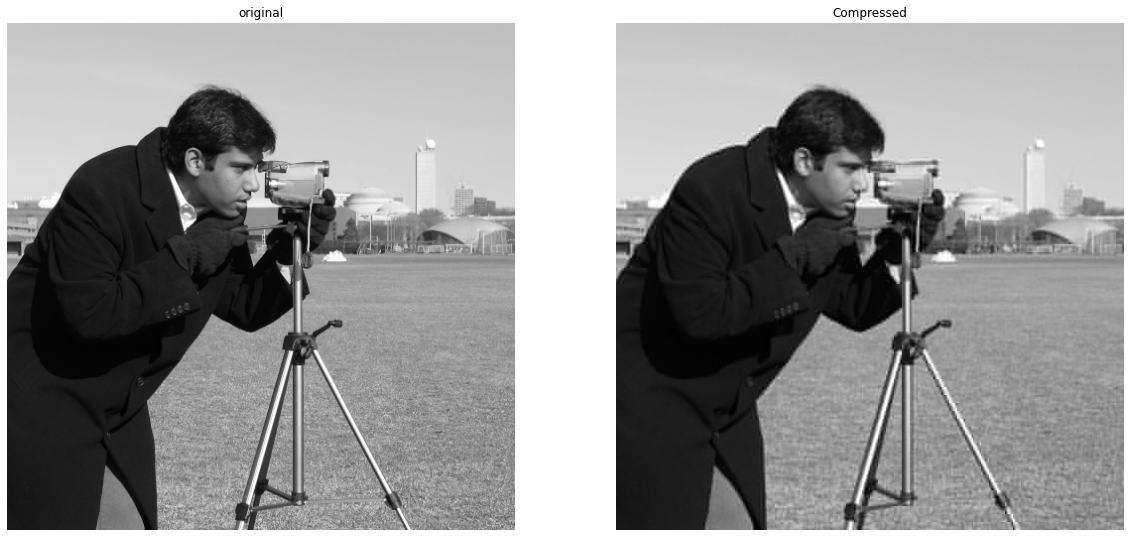

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('original')
ax1.axis('off')
ax2.imshow(result, cmap=plt.cm.gray)
ax2.set_title('Compressed')
ax2.axis('off')

# Wrapup

In [17]:
def create_mask(size, quality):
    k = max(int(quality*size/100),1)
    mask = []
    for i in range(size):
        if k>i:
            mask.append([1]*(k-i) + [0]*(size-k+i))
        else:
            mask.append([0]*size)
    return torch.tensor(mask)

In [18]:
def jpeg_compress(image, quality):
    x = torch.tensor(image).view(1,1,image.shape[0],image.shape[1])
    x = x.to(torch.float32)
    N=8

    bs, _, h, w = x.size()
    x = x.view(bs, 1, h, w)

    # make NxN blocs out of image
    blocks = torch.nn.functional.unfold(x, kernel_size=(N, N), stride=(N, N)) # shape (1, NxN, block_num)
    blocks = blocks.transpose(1, 2)
    blocks = blocks.view(bs, 1, -1, N, N) # shape (bs, 1, block_num, N, N)
    
    # apply DCT transform
    coeffs = _dct_matrix(N)

    if x.is_cuda:
        coeffs = coeffs.cuda()

    blocks = coeffs @ blocks @ coeffs.t() # @ does operation on last 2 channels only
    
    mask = create_mask(N, quality)
    blocks = mask.view(1, 1, 1, 8, 8).repeat(1, 1, blocks.size(2), 1, 1) * blocks
    blocks = coeffs.t() @ blocks @ coeffs
    
    # Reconstruct image
    blocks = blocks.view(bs, -1, N ** 2)
    blocks = blocks.transpose(1, 2)
    blocks = torch.nn.functional.fold(blocks, output_size=x.size()[-2:], kernel_size=(N, N), stride=(N, N))
    decomp = blocks.view(bs, 1, x.size(-2), x.size(-1))

    result = torch.clamp(decomp, 0, 255).view(decomp.size(-1), decomp.size(-2)).to(torch.uint8).numpy()
    return result

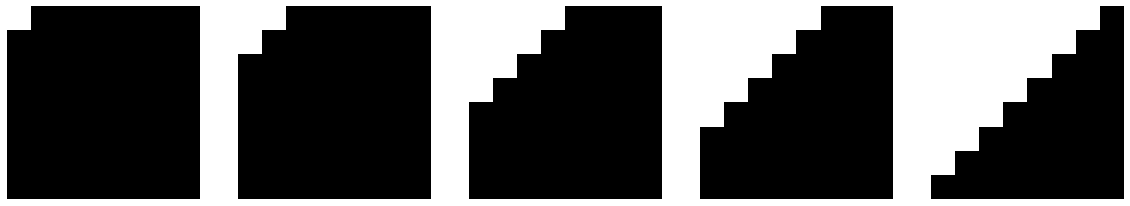

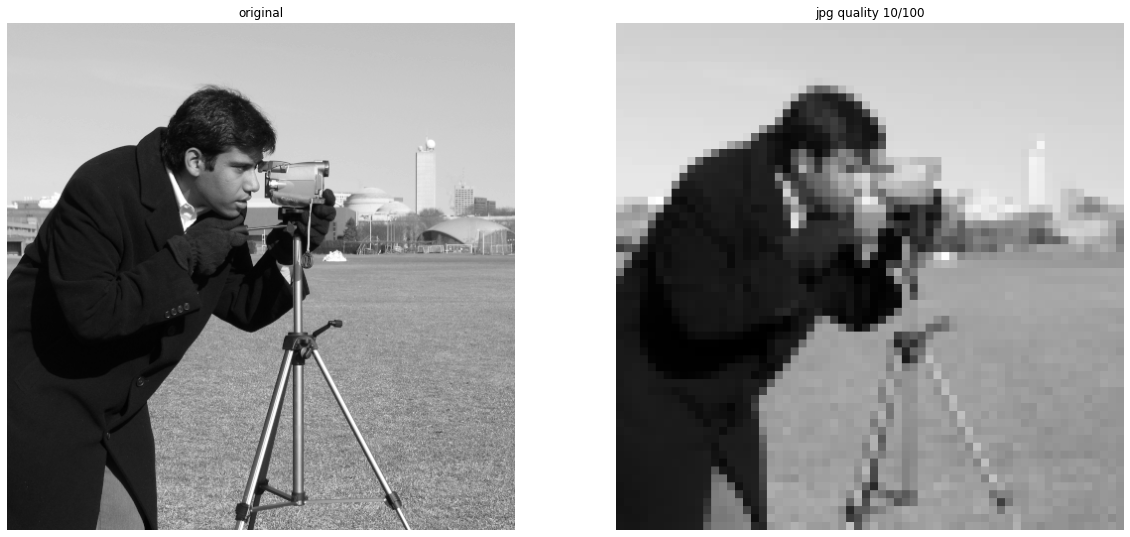

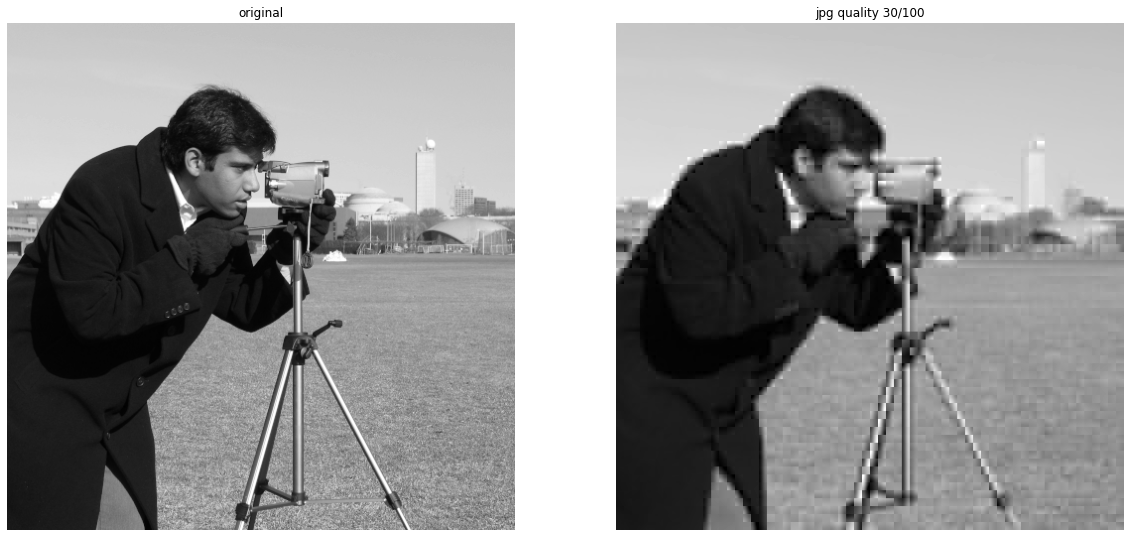

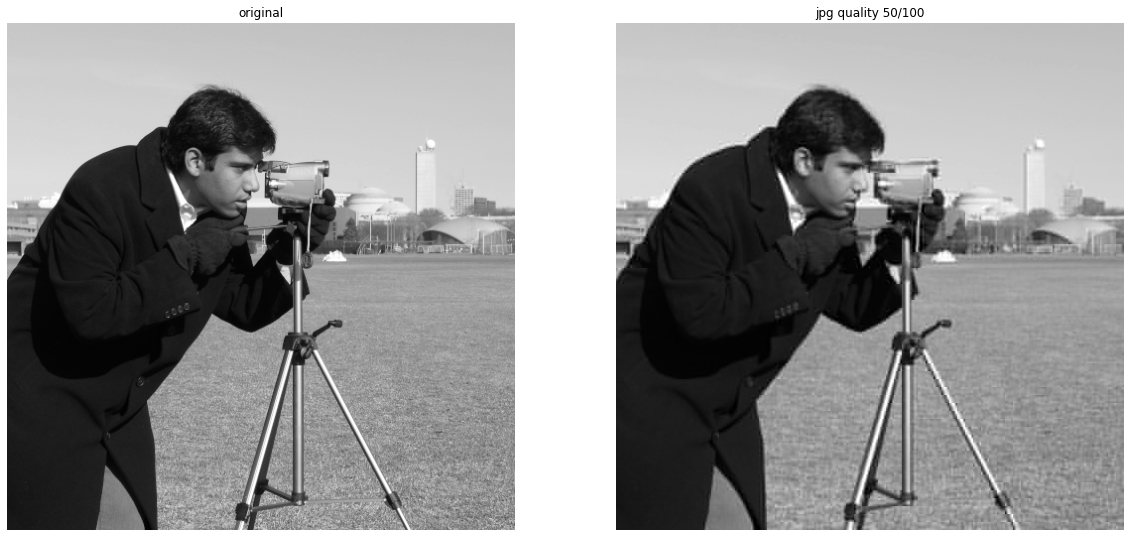

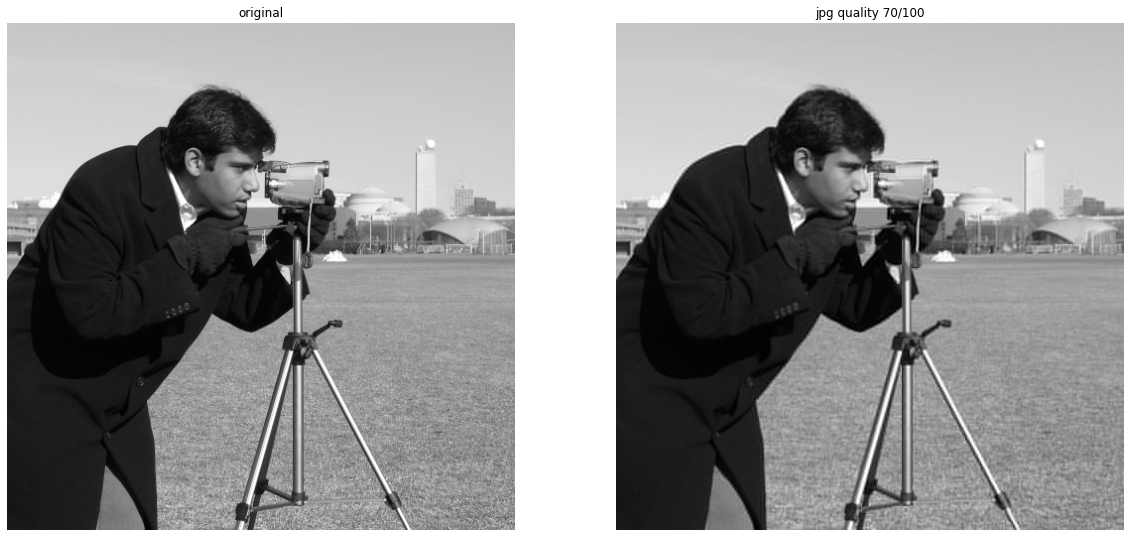

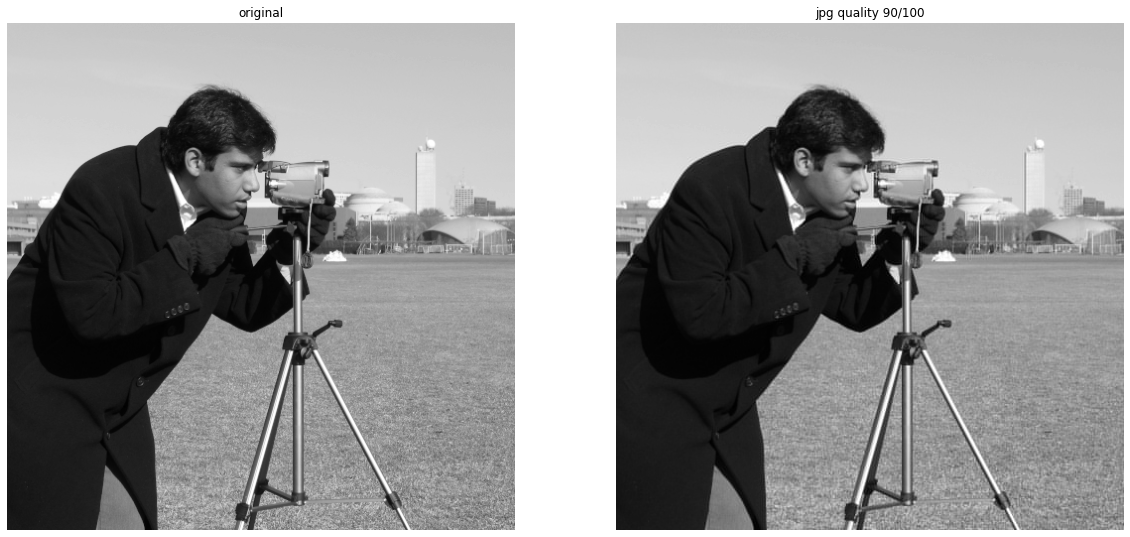

In [19]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
for i, quality in enumerate([10, 30, 50, 70, 90]):
    ax[i].imshow(create_mask(8, quality), cmap=plt.cm.gray)
    ax[i].axis('off')
    

for quality in [10, 30, 50, 70, 90]:
    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[0].axis('off')
    result = jpeg_compress(image, quality)
    ax[1].imshow(result, cmap=plt.cm.gray)
    ax[1].set_title(f'jpg quality {quality}/100')
    ax[1].axis('off')